In [1]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import torch.optim as optim
import torch.nn as nn
import torch
import numpy as np
import random
import warnings
import shutil
import os

warnings.filterwarnings('ignore')
matplotlib.style.use('ggplot')

In [2]:
# For reproducibility
seed = 27
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
dataset_path = 'C:/Users/Weronika/Desktop/vgg16/archive/chest_xray'

train_path = f'{dataset_path}/train/'
val_path = f'{dataset_path}/val/'
test_path = f'{dataset_path}/test/'

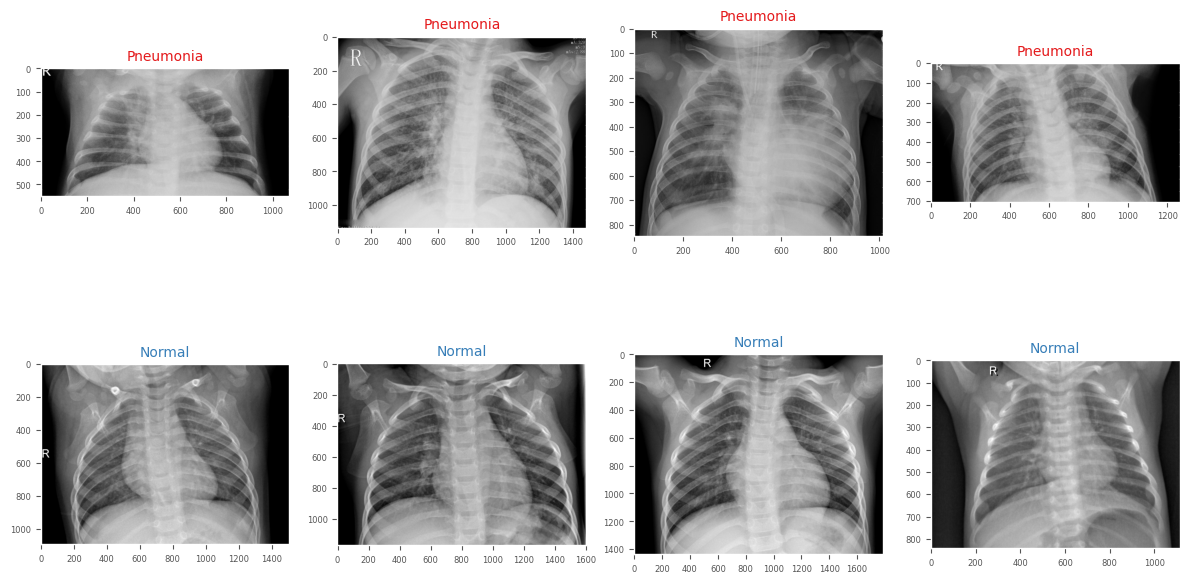

In [4]:
random_pneumonia_samples = random.sample(os.listdir(f'{train_path}/PNEUMONIA'), 4)
random_non_pneumonia_samples = random.sample(os.listdir(f'{train_path}/NORMAL'), 4)

plt.rcParams['axes.grid'] = False
colors = sns.color_palette('Set1', 2)
fig, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.flatten()

for i in range(4):
    filename = random_pneumonia_samples[i]
    image = Image.open(f'{train_path}/PNEUMONIA/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Pneumonia', color=colors[0], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)

for i in range(4, 8):
    filename = random_non_pneumonia_samples[i-5]
    image = Image.open(f'{train_path}/NORMAL/{filename}')
    ax[i].imshow(image, cmap='gray')
    ax[i].set_title('Normal', color=colors[1], fontsize=10)
    ax[i].tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.show()

In [5]:
def plot_label_distribution(train_path: str, val_path: str, test_path: str) -> None:
    plt.rcParams['axes.grid'] = True
    train_counts = [len(os.listdir(f'{train_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    val_counts = [len(os.listdir(f'{val_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    test_counts = [len(os.listdir(f'{test_path}/{cls}')) for cls in ['NORMAL', 'PNEUMONIA']]
    total_counts = [sum(x) for x in zip(train_counts, val_counts, test_counts)]

    total_train = sum(train_counts)
    total_val = sum(val_counts)
    total_test = sum(test_counts)
    total_images = sum(total_counts)

    fig, ax = plt.subplots(1, 4, figsize=(14, 5))
    bars0 = ax[0].bar(['Normal', 'Pneumonia'], train_counts, color=colors)
    ax[0].set_title('Train')
    ax[0].set_ylabel('Number of images')
    bars1 = ax[1].bar(['Normal', 'Pneumonia'], val_counts, color=colors)
    ax[1].set_title('Validation')
    bars2 = ax[2].bar(['Normal', 'Pneumonia'], test_counts, color=colors)
    ax[2].set_title('Test')
    bars3 = ax[3].bar(['Normal', 'Pneumonia'], total_counts, color=colors)
    ax[3].set_title('Total')

    def add_labels(bars, ax, total):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height} ({height / total:.1%})',
                    ha='center', va='bottom')

    add_labels(bars0, ax[0], total_train)
    add_labels(bars1, ax[1], total_val)
    add_labels(bars2, ax[2], total_test)
    add_labels(bars3, ax[3], total_images)

    plt.tight_layout()
    plt.show()

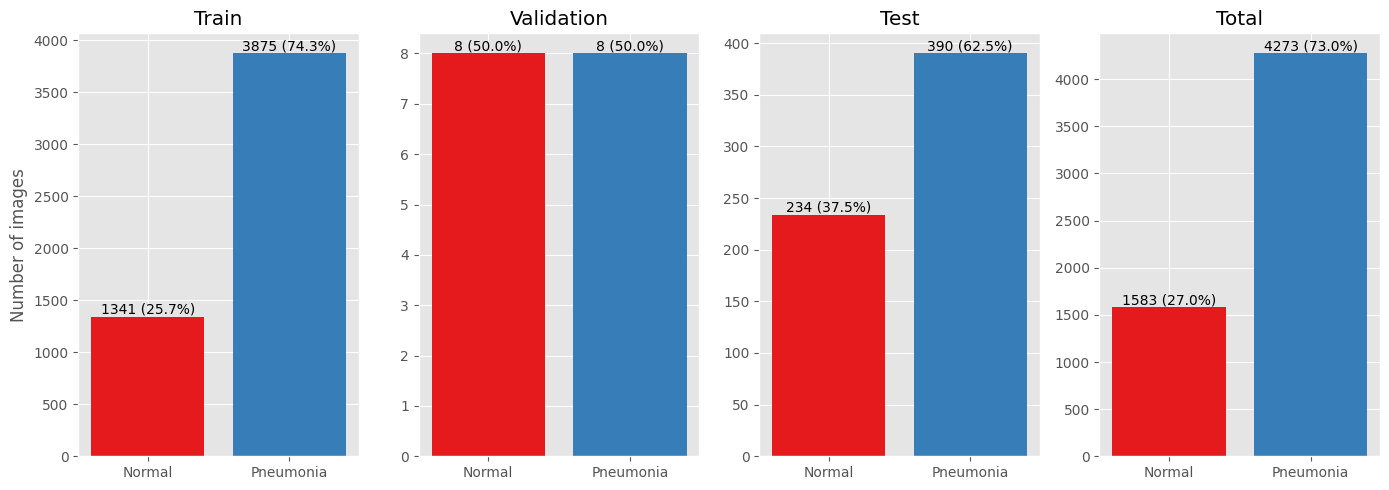

In [6]:
plot_label_distribution(train_path, val_path, test_path)

In [9]:
import os, shutil, random


dataset_path = r"C:\Users\Weronika\Desktop\vgg16\archive\chest_xray"

new_dataset_path = r"C:\Users\Weronika\Desktop\vgg16\chest_xray_new"

new_train_path = f"{new_dataset_path}/train/"
new_val_path   = f"{new_dataset_path}/val/"
new_test_path  = f"{new_dataset_path}/test/"

if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f"{new_dataset_path}/{split}/{cls}", exist_ok=True)
            
    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f"{dataset_path}/{split}/{cls}"
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])
        
        random.shuffle(all_files)
        
        train_files = all_files[:int(len(all_files)*0.8)]
        val_files   = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
        test_files  = all_files[int(len(all_files)*0.9):]
        
        for file, source_folder in train_files:
            shutil.copy(f"{source_folder}/{file}", f"{new_dataset_path}/train/{cls}/{file}")
        for file, source_folder in val_files:
            shutil.copy(f"{source_folder}/{file}", f"{new_dataset_path}/val/{cls}/{file}")
        for file, source_folder in test_files:
            shutil.copy(f"{source_folder}/{file}", f"{new_dataset_path}/test/{cls}/{file}")

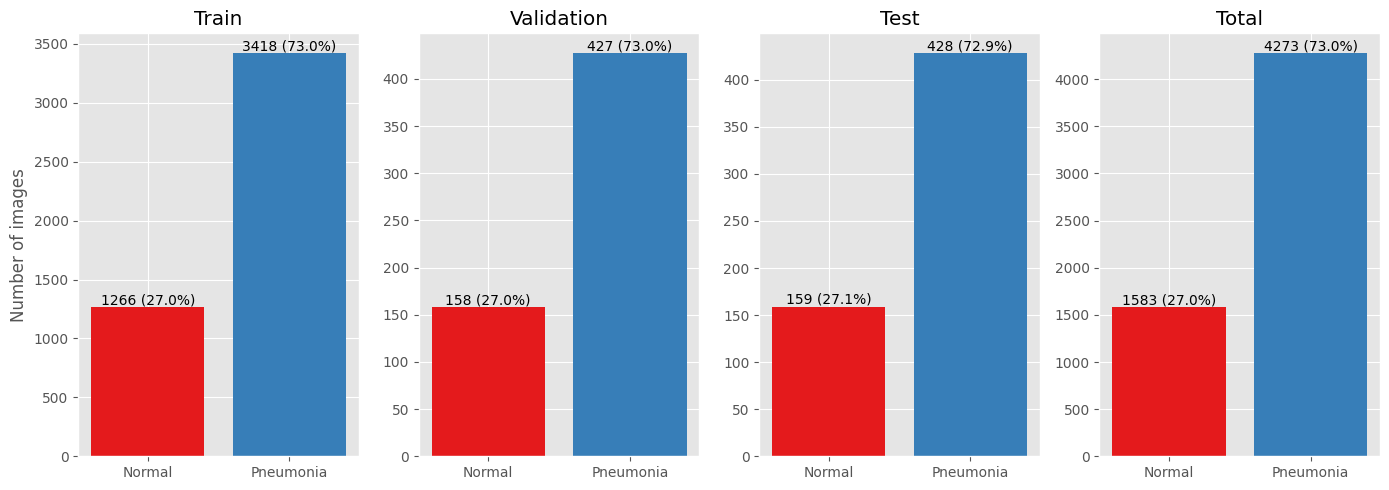

In [10]:
plot_label_distribution(new_train_path, new_val_path, new_test_path)


In [12]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(new_dataset_path, x), data_transforms[x]) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler._LRScheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str,
        pneumonia_samples: list
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None
        self.pneumonia_samples = pneumonia_samples


    def save_cam_samples(self, model: torch.nn.Module, epoch_nr: int) -> None:
        targets = [1, 1, 1, 1, 1]  # klasa PNEUMONIA = 1

        target_layer = [model.features[-1]]  # ostatnia warstwa konwolucyjna VGG16
        cam = GradCAM(model=model, target_layers=target_layer)
        plt.rcParams['axes.grid'] = False

        output_dir = r"C:\Users\Weronika\Desktop\vgg16\samples"
        os.makedirs(output_dir, exist_ok=True)

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        for image_path, target in zip(self.pneumonia_samples, targets):
            # 🖼️ Wczytaj obraz
            image = Image.open(image_path).convert("RGB")

            # Przygotuj tensor
            image_tensor = transform(image).unsqueeze(0).to(self.device)

            # Oblicz Grad-CAM
            grayscale_cam = cam(input_tensor=image_tensor,
                                targets=[ClassifierOutputTarget(target)])[0]

            # Przygotuj obraz w formacie numpy (0–1)
            rgb_image = np.array(image.resize((224, 224))) / 255.0
            visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

            # Zapisz wizualizację
            filename = os.path.basename(image_path).split('.')[0]
            out_path = os.path.join(output_dir, f"{filename}-cam-epoch-{epoch_nr}.jpeg")
            plt.imsave(out_path, visualization)
            print(f"✅ Zapisano mapę Grad-CAM: {out_path}")

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()
        running_loss, n_corrects, total = 0.0, 0, 0

        if current_epoch_nr == 1:
            self.save_cam_samples(self.model, 0)

        loop = tqdm(self.train_dataloader, desc=f"Epoch {current_epoch_nr}")
        for x, y in loop:
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()
            y_hat = self.model(x)
            loss = self.criterion(y_hat, y)
            _, preds = torch.max(y_hat, 1)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).item()
            total += y.size(0)

            loop.set_postfix(train_acc=round(n_corrects / total, 4),
                             train_loss=round(running_loss / total, 4))

        self.scheduler.step()

        return n_corrects / total, running_loss / total

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()
        running_loss, n_corrects, total = 0.0, 0, 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, desc=f"Validation {current_epoch_nr}")
            for x, y in loop:
                x, y = x.to(self.device), y.to(self.device)
                y_hat = self.model(x)
                loss = self.criterion(y_hat, y)
                _, preds = torch.max(y_hat, 1)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).item()
                total += y.size(0)

                loop.set_postfix(val_acc=round(n_corrects / total, 4),
                                 val_loss=round(running_loss / total, 4))

        val_accuracy = n_corrects / total
        val_loss = running_loss / total

     
        self.save_cam_samples(self.model, current_epoch_nr)
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f"epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth"
            save_path = os.path.join(self.checkpoint_path, checkpoint_name)
            torch.save(self.model.state_dict(), save_path)
            self.best_model_path = save_path
            print(f"💾 Zapisano najlepszy model: {save_path}")

        return val_accuracy, val_loss

 
    def test(self) -> Tuple[float, float, list, list, torch.nn.Module]:
        self.model.eval()
        running_loss, n_corrects, total = 0.0, 0, 0
        targets, predictions = [], []

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, desc="Testing")
            for x, y in loop:
                x, y = x.to(self.device), y.to(self.device)
                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).item()
                total += y.size(0)

                targets.extend(y.cpu().numpy())
                predictions.extend(preds.cpu().numpy())

                loop.set_postfix(test_acc=round(n_corrects / total, 4),
                                 test_loss=round(running_loss / total, 4))

        test_accuracy = n_corrects / total
        test_loss = running_loss / total
        print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
        print(f"✅ Test Loss: {test_loss:.4f}")

        if self.best_model_path:
            self.model.load_state_dict(torch.load(self.best_model_path))
            print(f"📦 Wczytano najlepszy model z: {self.best_model_path}")

        return test_accuracy, test_loss, targets, predictions, self.model


In [ ]:
# 📸 Przykładowe obrazy testowe do wizualizacji Grad-CAM
new_test_path = r"C:\Users\Weronika\Desktop\gradcam\chest_xray_new\test"

pneumonia_samples = [
    os.path.join(new_test_path, "PNEUMONIA", "person547_bacteria_2296.jpeg"),
    os.path.join(new_test_path, "PNEUMONIA", "person1038_virus_1733.jpeg"),
    os.path.join(new_test_path, "PNEUMONIA", "person1308_bacteria_3280.jpeg"),
    os.path.join(new_test_path, "PNEUMONIA", "person1473_bacteria_3836.jpeg"),
    os.path.join(new_test_path, "PNEUMONIA", "person308_bacteria_1445.jpeg"),
]


samples_dir = r"C:\Users\Weronika\Desktop\vgg16\samples"
os.makedirs(samples_dir, exist_ok=True)


for sample in pneumonia_samples:
    if os.path.exists(sample):
        img = Image.open(sample)
        dest_path = os.path.join(samples_dir, os.path.basename(sample))
        img.save(dest_path)
        print(f" Skopiowano: {dest_path}")
    else:
        print(f"Nie znaleziono pliku: {sample}")


📸 Skopiowano: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296.jpeg
📸 Skopiowano: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733.jpeg
📸 Skopiowano: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280.jpeg
📸 Skopiowano: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836.jpeg
📸 Skopiowano: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445.jpeg


In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Wczytaj VGG16 z wagami ImageNet
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Odblokuj gradienty (potrzebne do Grad-CAM)
for p in model.features.parameters():
    p.requires_grad = True

# Liczba klas (np. NORMAL i PNEUMONIA)
n_classes = len(class_names)

# Podmień ostatnią warstwę klasyfikatora
n_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(n_features, n_classes)


model = model.to(device)

# Kryterium i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# Zamroź wcześniejsze warstwy (do transfer learningu)
for param in model.features[:-5].parameters():
    param.requires_grad = False


In [ ]:
max_epochs = 10
train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']


checkpoint_path = r"C:\Users\Weronika\Desktop\vgg16\checkpoints"
os.makedirs(checkpoint_path, exist_ok=True)


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path,
    pneumonia_samples=pneumonia_samples
)


histories = []
for epoch in range(1, max_epochs + 1):
    print(f"\n🔹 Epoch {epoch}/{max_epochs}")
    
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })


test_acc, test_loss, targets, predictions, best_model = trainer.test()

print(f"\n Final Test Accuracy: {test_acc:.4f}")
print(f" Final Test Loss: {test_loss:.4f}")
print(f" Najlepszy model zapisany w: {trainer.best_model_path}")



🔹 Epoch 1/10
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-0.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-0.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-0.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-0.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-0.jpeg


Validation 1: 100%|██████████| 37/37 [00:04<00:00,  7.91it/s, val_acc=0.954, val_loss=0.142]


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-1.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-1.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-1.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-1.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-1.jpeg
💾 Zapisano najlepszy model: C:\Users\Weronika\Desktop\vgg16\checkpoints\epoch_1_acc_0.95.pth

🔹 Epoch 2/10


Validation 2: 100%|██████████| 37/37 [00:03<00:00,  9.73it/s, val_acc=0.904, val_loss=0.232]


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-2.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-2.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-2.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-2.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-2.jpeg

🔹 Epoch 3/10


Validation 3: 100%|██████████| 37/37 [00:03<00:00,  9.65it/s, val_acc=0.942, val_loss=0.27] 


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-3.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-3.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-3.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-3.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-3.jpeg

🔹 Epoch 4/10


Validation 4: 100%|██████████| 37/37 [00:03<00:00,  9.52it/s, val_acc=0.957, val_loss=0.243] 


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-4.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-4.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-4.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-4.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-4.jpeg
💾 Zapisano najlepszy model: C:\Users\Weronika\Desktop\vgg16\checkpoints\epoch_4_acc_0.96.pth

🔹 Epoch 5/10


Validation 5: 100%|██████████| 37/37 [00:03<00:00,  9.54it/s, val_acc=0.956, val_loss=0.221]


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-5.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-5.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-5.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-5.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-5.jpeg

🔹 Epoch 6/10


Validation 6: 100%|██████████| 37/37 [00:03<00:00,  9.40it/s, val_acc=0.932, val_loss=0.159]


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-6.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-6.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-6.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-6.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-6.jpeg

🔹 Epoch 7/10


Validation 7: 100%|██████████| 37/37 [00:03<00:00,  9.44it/s, val_acc=0.939, val_loss=0.247]


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-7.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-7.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-7.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-7.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-7.jpeg

🔹 Epoch 8/10


Validation 8: 100%|██████████| 37/37 [00:03<00:00,  9.53it/s, val_acc=0.957, val_loss=0.132] 


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-8.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-8.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-8.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-8.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-8.jpeg

🔹 Epoch 9/10


Validation 9: 100%|██████████| 37/37 [00:03<00:00,  9.66it/s, val_acc=0.959, val_loss=0.112] 


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-9.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-9.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-9.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-9.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-9.jpeg
💾 Zapisano najlepszy model: C:\Users\Weronika\Desktop\vgg16\checkpoints\epoch_9_acc_0.96.pth

🔹 Epoch 10/10


Validation 10: 100%|██████████| 37/37 [00:03<00:00,  9.59it/s, val_acc=0.957, val_loss=0.121] 


✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person547_bacteria_2296-cam-epoch-10.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1038_virus_1733-cam-epoch-10.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1308_bacteria_3280-cam-epoch-10.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person1473_bacteria_3836-cam-epoch-10.jpeg
✅ Zapisano mapę Grad-CAM: C:\Users\Weronika\Desktop\vgg16\samples\person308_bacteria_1445-cam-epoch-10.jpeg


Testing: 100%|██████████| 37/37 [00:04<00:00,  8.26it/s, test_acc=0.944, test_loss=0.145]


✅ Test Accuracy: 0.9438
✅ Test Loss: 0.1451
📦 Wczytano najlepszy model z: C:\Users\Weronika\Desktop\vgg16\checkpoints\epoch_9_acc_0.96.pth

✅ Final Test Accuracy: 0.9438
✅ Final Test Loss: 0.1451
📁 Najlepszy model zapisany w: C:\Users\Weronika\Desktop\vgg16\checkpoints\epoch_9_acc_0.96.pth


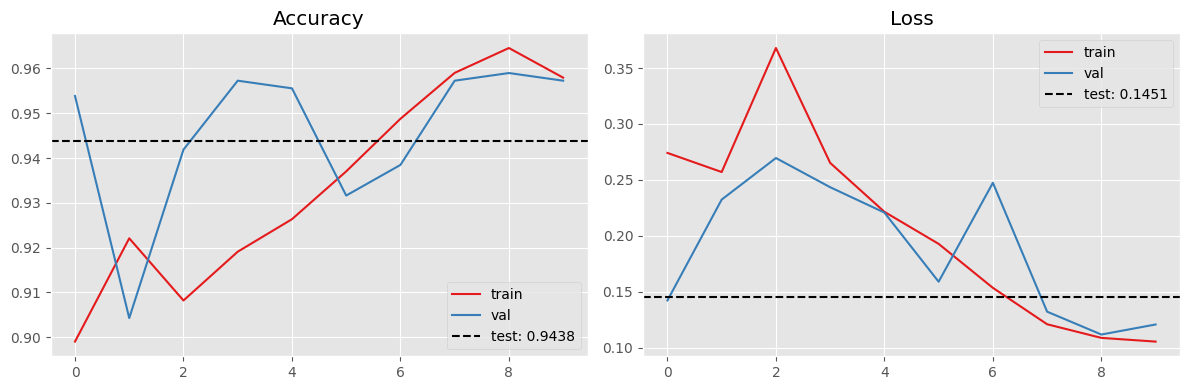

In [23]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.rcParams['axes.grid'] = True
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train', color=colors[0])
plt.plot(val_accs, label='val', color=colors[1])
plt.axhline(y=test_acc, color='black', linestyle='--', label=f'test: {test_acc:.4f}')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train', color=colors[0])
plt.plot(val_losses, label='val', color=colors[1])
plt.axhline(y=test_loss, color='black', linestyle='--', label=f'test: {test_loss:.4f}')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

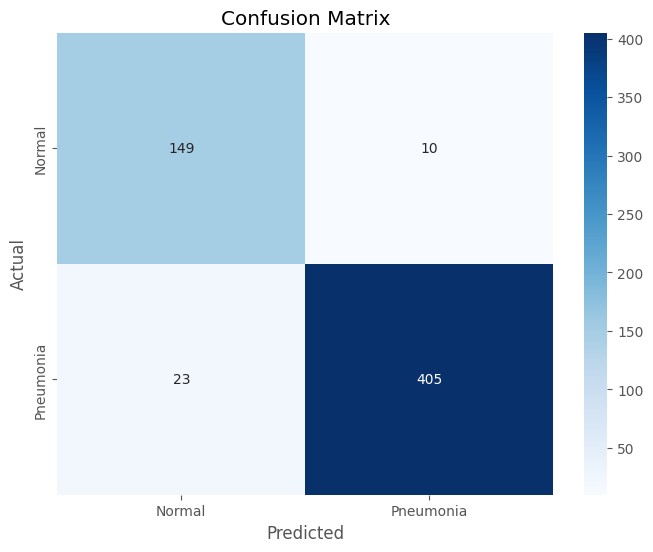

In [24]:
cm = confusion_matrix(targets, predictions)

plt.rcParams['axes.grid'] = False
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
print(classification_report(targets, predictions, target_names=['Normal', 'Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.87      0.94      0.90       159
   Pneumonia       0.98      0.95      0.96       428

    accuracy                           0.94       587
   macro avg       0.92      0.94      0.93       587
weighted avg       0.95      0.94      0.94       587



In [ ]:
def plot_cam(model: models.vgg.VGG, image_paths: list, targets: list) -> None:
    model = model.eval()
    
   
    target_layer = [model.features[-1]]  # zamiast model.Mixed_7c
    cam = GradCAM(model=model, target_layers=target_layer)

    plt.rcParams['axes.grid'] = False
    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')

        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        image_tensor = transform(image).unsqueeze(0)

     
        image_vis = np.array(image.resize((224, 224))) / 255.0
        grayscale_cam = cam(input_tensor=image_tensor, targets=[ClassifierOutputTarget(target)])
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(image_vis, grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image_vis)
        axs[1, i].set_title('Original')
        axs[1, i].tick_params(axis='both', which='major', labelsize=6)

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('Grad-CAM')
        axs[0, i].tick_params(axis='both', which='major', labelsize=6)

    plt.tight_layout()
    plt.show()


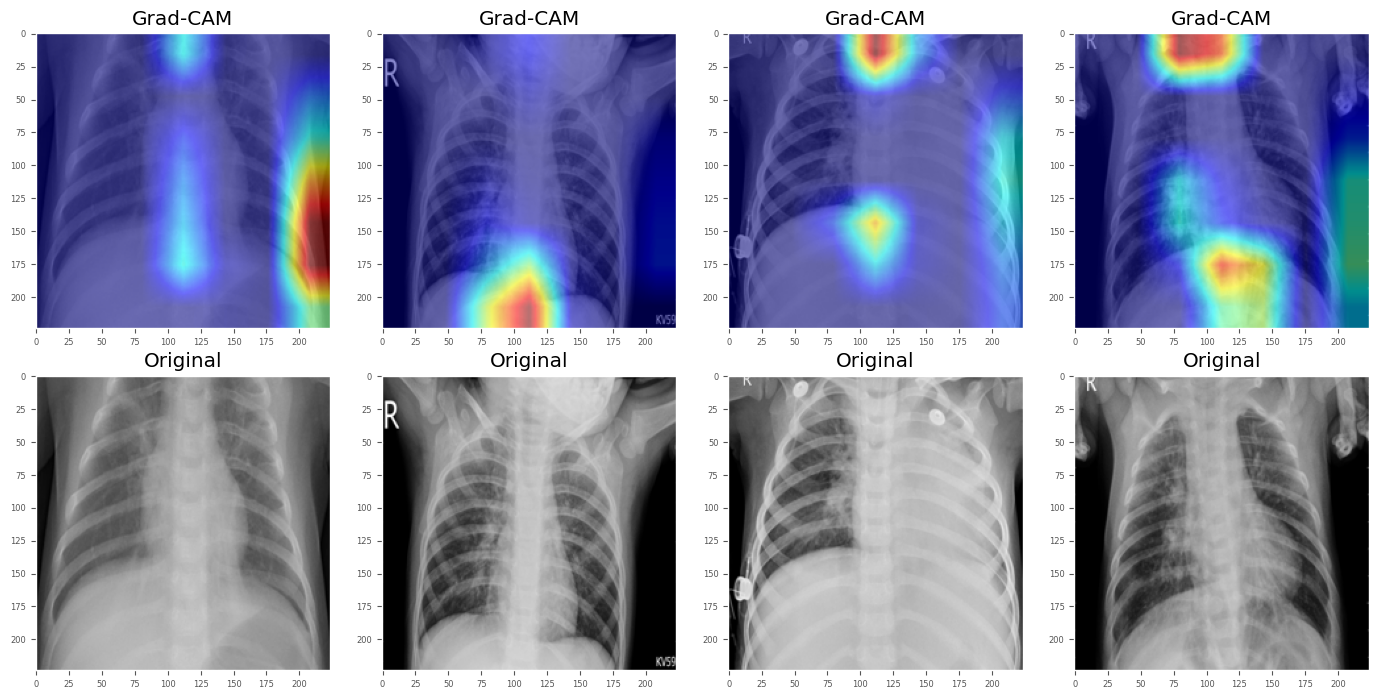

In [31]:
image_paths = pneumonia_samples
plot_cam(best_model, image_paths, [1] * 4)


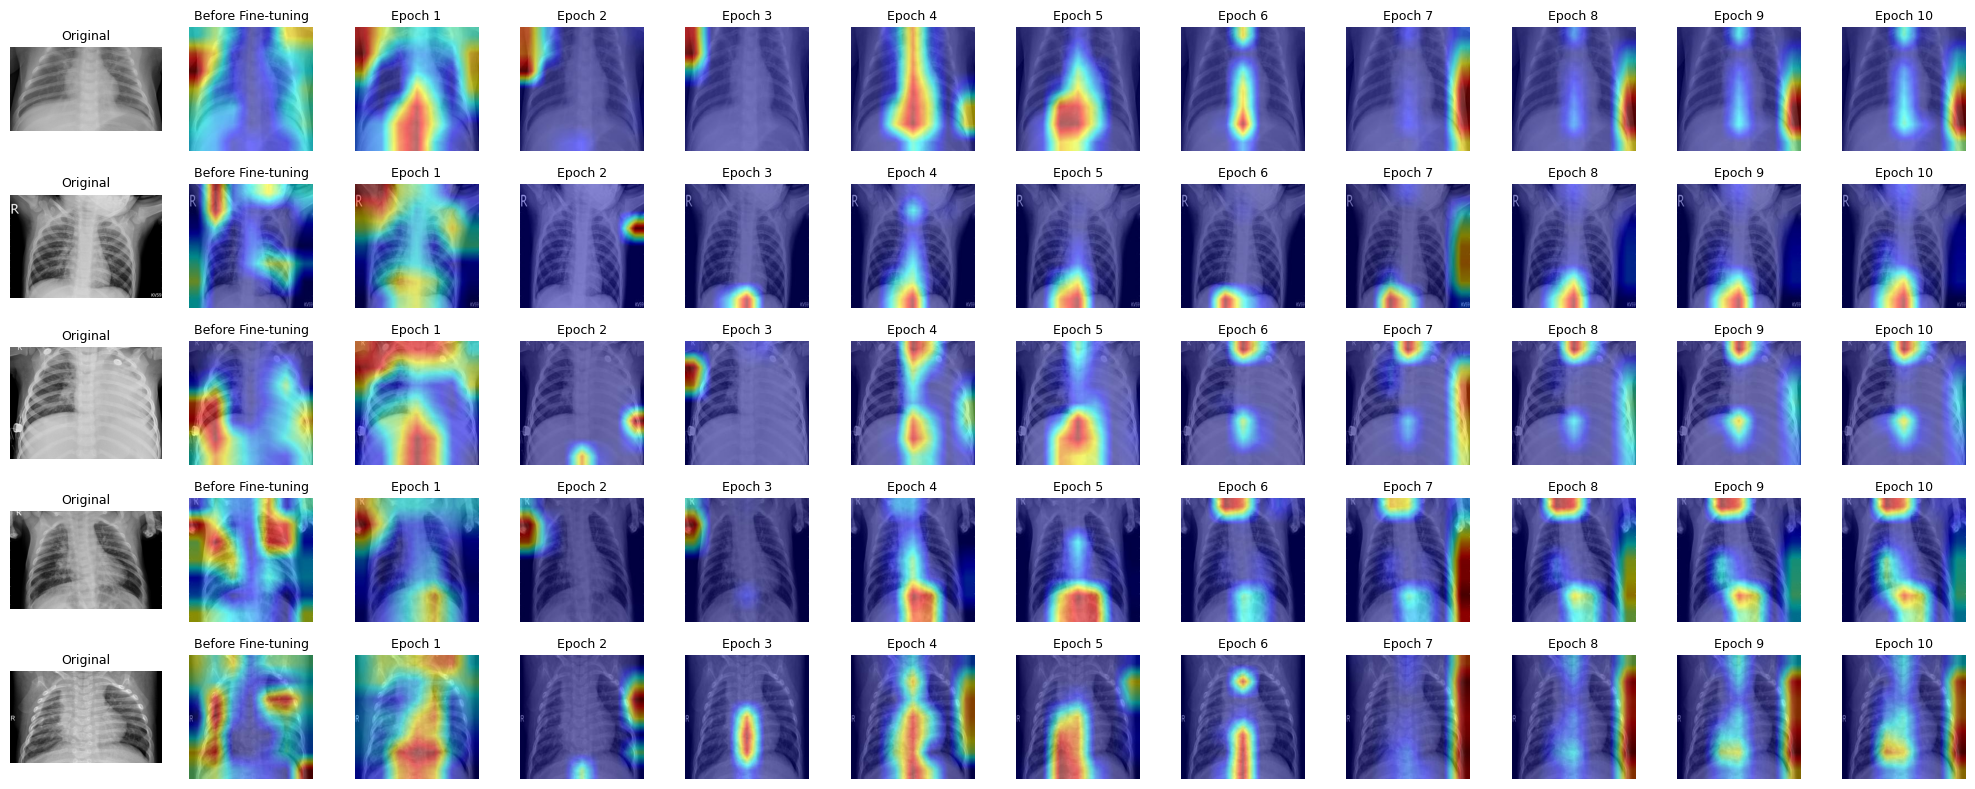

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image


samples_path = r"C:\Users\Weronika\Desktop\vgg16\samples"


fig, axs = plt.subplots(len(pneumonia_samples), max_epochs + 2, figsize=(20, 8))

for row, img_path in enumerate(pneumonia_samples):
    # Oryginał
    orig_img = Image.open(img_path)
    axs[row, 0].imshow(orig_img, cmap='gray')
    axs[row, 0].set_title('Original', fontsize=9)
    axs[row, 0].axis('off')

    base_name = os.path.splitext(os.path.basename(img_path))[0]

    for col in range(1, max_epochs + 2):
        cam_path = os.path.join(samples_path, f"{base_name}-cam-epoch-{col-1}.jpeg")

        if os.path.exists(cam_path):
            cam_img = Image.open(cam_path)
            axs[row, col].imshow(cam_img, cmap='gray')
        else:
          
            axs[row, col].imshow([[0]], cmap='gray')

        # tytuły
        if col == 1:
            title = 'Before Fine-tuning'
        else:
            title = f'Epoch {col - 1}'
        axs[row, col].set_title(title, fontsize=9)
        axs[row, col].axis('off')

plt.tight_layout()
plt.show()
